# French web domain classification

Team GCM : Camille Cochet - Mithuran Gajendran - Hugo Mallet

In [36]:
import os
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
import codecs
from os import path
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from nltk.stem.snowball import FrenchStemmer
import re
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import FastText
import nltk
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

We based our code on the text baseline which was provided in with the challenge. We proposed 2 solutions:
* based on TF-IDF feature extractor
* based on FastText

## First Model: TF-IDF

### Reading the data

In [2]:
# Read training data
with open("train.csv", 'r') as f:
    train_data = f.read().splitlines()

train_hosts = list()
y_train = list()
for row in train_data:
    host, label = row.split(",")
    train_hosts.append(host)
    y_train.append(label.lower())

# Read test data
with open("test.csv", 'r') as f:
    test_hosts = f.read().splitlines()

# Load the textual content of a set of webpages for each host into the dictionary "text". 
# The encoding parameter is required since the majority of our text is french.
text = dict()
filenames = os.listdir('text/text')
for filename in filenames:
    try :
        with open('text/text/' + filename,encoding="utf-8") as f: 
                text[filename] = f.read().replace("\n", "").lower()
    except :
        with open('text/text/' + filename,encoding="latin-1") as f: 
                text[filename] = f.read().replace("\n", "").lower()

train_data = list()
for host in train_hosts:
    if host in text:
        train_data.append(text[host])
    else:
        train_data.append('')

### Preprocessing

The preprocessing includes several steps : 
* Transform all characters to lowercase in order to make the training consistent
* Tokenization: Extract words from text while getting rid of white-spaces and punctuations
* StopWords removing: Remove French and English stopwords that have no semantic meaning
* Stemming: Stemming words to reduce tokens to their root form.

In [3]:
#Initializing a list of stopwords that will not be useful for our analysis.
stopwords_list = set(stopwords.words('french') + stopwords.words('english'))
# Adding common web words to the stopward list
stopwords_suppl = ["button", "connexion","nginx", "fermer", 
                   "recherche", "newsletter", "rss", "mentions légales", "plan du site",
                  "toggle", "navigation","copyright", "search","home","copyright", "contact","privacy","about",
                  "alternate","menu"]
stopwords_list.update(stopwords_suppl)
#Initializing stemming
stemmer_french = FrenchStemmer()
stemmer_english = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r'\w+')


# Class that will pre process our data.

def data_cleaning(string) : 

    output = string.replace("_","")
    output=re.sub(r'[\u4e00-\u9fff]+'," ", output)
    output = ''.join(c for c in output if not c.isdigit())
    word_tokens = tokenizer.tokenize(output)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stopwords_list and len(w)>2:
            filtered_sentence.append(w)
            
    filtered_sentence = list(map(lambda x :stemmer_french.stem(x),filtered_sentence))
    filtered_sentence = list(map(lambda x :stemmer_english.stem(x),filtered_sentence))

    return filtered_sentence

#Cleaning our train data
train_data_2 = list(map(data_cleaning,train_data))

In [4]:
# Get textual content of web hosts of the test set
test_data = list()
for host in test_hosts:
    if host in text:
        test_data.append(text[host])
    else:
        test_data.append('')

In [5]:
#Cleaning test data 
test_data_2 = list(map(data_cleaning,test_data))

In [6]:
#Operating Detokenization on our data
train_data_3 = list(map(lambda x : TreebankWordDetokenizer().detokenize(x),train_data_2))
test_data_3 = list(map(lambda x : TreebankWordDetokenizer().detokenize(x),test_data_2))

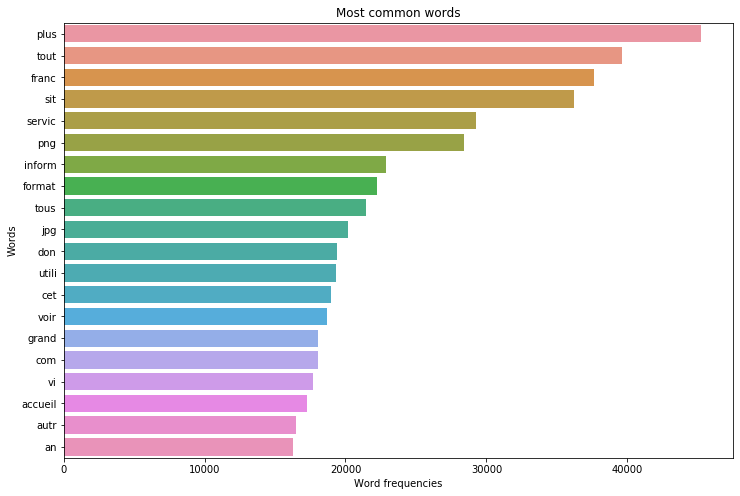

In [10]:
train_data_3_join = ' '.join(train_data_3)

dist = nltk.FreqDist(train_data_3_join.split()) # Get the frequency of words

y, X = [nb[0] for nb in dist.most_common(20)] ,[nb[1] for nb in dist.most_common(20)]
plt.figure(figsize=(12,8))
ax = sns.barplot(X,y)
ax.set(xlabel='Word frequencies',ylabel='Words',title='Most common words')
plt.show()

### Feature Extraction

Our first model is based on Term Frequency-Inverse Document Frequency (TF-IDF) representation. It measures how important a word is to a document.

In [11]:
#Using tfidf on the data.
vec = TfidfVectorizer(decode_error='ignore', strip_accents='unicode', encoding='utf-8', min_df=1, max_df=2500, stop_words=stopwords_list, sublinear_tf= True)#, ngram_range=(1, 2))
X_train = vec.fit_transform(train_data_3)

# Create the test matrix following the same approach as in the case of the training matrix
X_test = vec.transform(test_data_3)

### Classification

The most efficient classifier that allowed us to reach the score of 1.02017 on Kaggle is the **SGDClassifier** using a Logistic Regression. We tuned parameters so that the classification takes into account Balanced data, and found the best learning rate to be 0.00002.

In [14]:
#Classifier
clf = SGDClassifier(loss='log', penalty='l2', tol=None, learning_rate= 'optimal', eta0=0.15, class_weight= "balanced", alpha= 0.00002, fit_intercept=True)
clf.fit(X_train, y_train)
#Prediction
y_pred = clf.predict_proba(X_test)

# Write predictions to a file
with open('text_model1.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = clf.classes_.tolist()
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i,test_host in enumerate(test_hosts):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

## Second Model: FastText

### Reading the data

In [15]:
init_col_name = ['host', 'label']
df = pd.read_csv("train.csv", header=None, names=init_col_name)

In [16]:
# Load the textual content of a set of webpages for each host into the dictionary "text". 
# The encoding parameter is required since the majority of our text is french.
text = dict()
filenames = os.listdir('text/text')
for filename in filenames:
    try :
        with open('text/text/' + filename,encoding="utf-8") as f: 
                text[filename] = f.read().replace("\n", "").lower()
    except :
        with open('text/text/' + filename,encoding="latin-1") as f: 
                text[filename] = f.read().replace("\n", "").lower()

In [17]:
text_for_df= list()
for host in df.host.to_numpy():
    if str(host) in text:
        text_for_df.append(text[str(host)])
    else:
        text_for_df.append('')
df['text'] = text_for_df

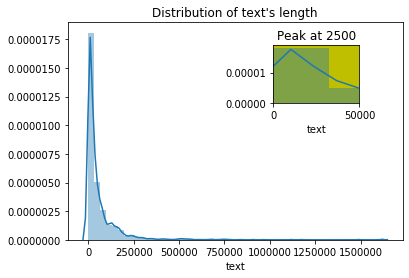

In [18]:
d = df.text.apply(lambda x:len(x))

fig, ax = plt.subplots()
ax.set_title("Distribution of text's length")
sns.distplot(d, ax=ax)
ax2 = plt.axes([0.6, 0.6, .2, .2], facecolor='y')
sns.distplot(d,ax=ax2)
ax2.set_title('Peak at 2500')
ax2.set_xlim([-10,50000]);

In [19]:
df1 = df.copy()
df1.text = list(map(data_cleaning,df1.text))

In [21]:
init_col_name = ['host']
df_sub = pd.read_csv("test.csv", header=None, names=init_col_name)
text = dict()
filenames = os.listdir('text/text')
for filename in filenames:
    try :
        with open('text/text/' + filename,encoding="utf-8") as f: 
                text[filename] = f.read().replace("\n", "").lower()
    except :
        with open('text/text/' + filename,encoding="latin-1") as f: 
                text[filename] = f.read().replace("\n", "").lower()
        
text_for_df= list()
for host in df_sub.host.to_numpy():
    if str(host) in text:
        text_for_df.append(text[str(host)])
    else:
        text_for_df.append('')
df_sub['text'] = text_for_df

In [22]:
df_sub.text = list(map(data_cleaning,df_sub.text))

### Feature Extraction

We turned ourselves toward Facebook’s solution: FastText (2016). It allows training word embeddings from a training corpus with the additional ability to obtain word vectors for out-of-vocabulary words. We enriched word vectors with subword called n-grams.

In [ ]:
y = df1[["label","host"]]
X = df1.drop("label", axis=1)

X_train = X.copy()
y_train = y.copy()

In [24]:
def vectorizer_word2vec(string):
    return model_ted.wv.get_vector(string)

size=100
model_ted = FastText(X_train.text, size=size, window=5, min_count=5, workers=4,sg=1)

After having trained our FastText model, we replaced all the words of a corpus by their vectors and then calculated the corpus mean.

In [25]:
X_train.text = X_train.text.apply(lambda x: [vectorizer_word2vec(el) for el in x])
X_train.text = X_train.text.apply(lambda x : np.mean(x,axis=0))
X_train.text = X_train.text.apply(lambda x : np.zeros(size) if np.all(np.isnan(x)) else x)

In [27]:
df_sub.text = df_sub.text.apply(lambda x: x[len(x)//4:3*len(x)//4]) 
df_sub.text =df_sub.text.apply(lambda x: [vectorizer_word2vec(el) for el in x])
df_sub.text = df_sub.text.apply(lambda x : np.mean(x,axis=0))
df_sub.text = df_sub.text.apply(lambda x : np.zeros(100) if np.all(np.isnan(x)) else x)

#### t-SNE representation

An easy way to verify that our model is effectively learning is to check whether its embedding representation makes sense. We  used  T-distributed Stochastic Neighbor Embedding (t-SNE). 

In [37]:
def visualize_doc_embeddings(my_doc_embs,my_colors,my_labels,my_name):
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
    doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
    doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)
    
    fig, ax = plt.subplots()

    inv = le.inverse_transform(list(set(my_labels)))
    i = 0
    
    for label in list(set(my_labels)):

        idxs = [idx for idx,elt in enumerate(my_labels) if elt==label]
        ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                   c = my_colors[label],
                   label=inv[i],
                   alpha=0.7,
                   s=40)
        i += 1
    
    ax.legend(scatterpoints=1)
    fig.suptitle('t-SNE visualization doc embeddings',fontsize=15)
    fig.set_size_inches(11,7)

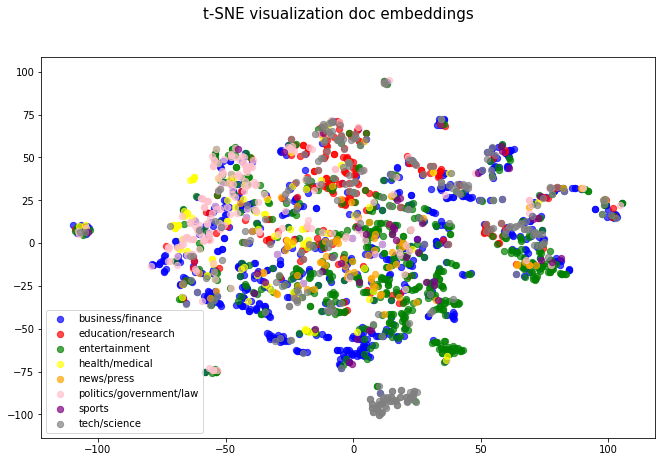

In [32]:
le = preprocessing.LabelEncoder()
le.fit(y_train.label)
y_train_enc = le.transform(y_train.label)

visualize_doc_embeddings(np.stack(X_train.text.values),['blue','red',"green","yellow","orange","pink","purple","grey"],y_train_enc,"TSNE")

### Classification

The most efficient classifier that allowed us to reach the score of 1.06035 on Kaggle is the **SGDClassifier** using a Logistic Regression.

In [33]:
clf = SGDClassifier(loss='log', penalty='l2', tol=None,
              learning_rate= 'optimal', eta0=0.15, class_weight= None, 
                    alpha= 0.00001,fit_intercept=False,random_state=50)

clf.fit(list(X_train.text.to_numpy()), y_train.label)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.15, fit_intercept=False,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=50, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [35]:
y_pred = clf.predict_proba(list(df_sub.text.to_numpy()))

# Write predictions to a file
with open('text_model2.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = clf.classes_.tolist()
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i,test_host in enumerate(df_sub.host):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)